In [62]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, accuracy_score

In [63]:
df = pd.read_csv('/Users/hashibk/Documents/Internship/week3/Mall_Customers.csv')
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [64]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [65]:
df.duplicated().sum()

np.int64(0)

In [66]:
df.shape

(200, 5)

In [67]:
le = LabelEncoder()
df['Genre'] = le.fit_transform(df['Genre'])
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40
...,...,...,...,...,...
195,196,0,35,120,79
196,197,0,45,126,28
197,198,1,32,126,74
198,199,1,32,137,18


In [68]:
upper_bound = {}
lower_bound = {}

for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound[col] = q3 + 1.5 * iqr
    lower_bound[col] = q1 - 1.5 * iqr

for col in df.columns:
    df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]

df = df.drop(columns=['CustomerID'])
df.shape

(198, 4)

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))           
X_scaled = pd.DataFrame(X_scaled, columns=df.select_dtypes(include=['float64', 'int64']).columns)
X_scaled

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.141195,-1.425414,-1.779171,-0.435989
1,1.141195,-1.282367,-1.779171,1.199413
2,-0.876275,-1.353890,-1.739447,-1.720949
3,-0.876275,-1.139319,-1.739447,1.043661
4,-0.876275,-0.567131,-1.699723,-0.397051
...,...,...,...,...
193,-0.876275,-0.066466,2.113819,1.588795
194,-0.876275,0.577246,2.391890,-1.331567
195,-0.876275,-0.281037,2.391890,1.121537
196,-0.876275,0.434198,2.630236,-0.864309


In [70]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

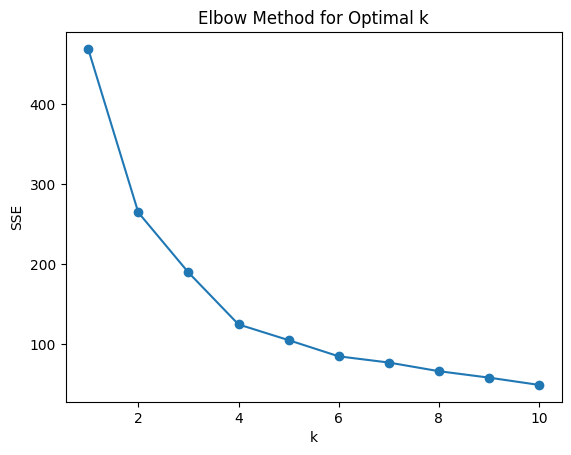

In [71]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

plt.plot(range(1,11), sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [72]:
labels = KMeans(n_clusters=6, random_state=42).fit_predict(X_pca)
silhouette_score(X_pca, labels)
#for pca

0.39358246983690554

In [73]:

silhouette_score(X_scaled, KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled))
#for scaled

0.38177771336302013

In [74]:
k = 4  # based on elbow/silhouette
X = X_pca
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_pca)
df['Cluster'] = labels

In [75]:
df

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,1
1,1,21,15,81,1
2,0,20,16,6,2
3,0,23,16,77,1
4,0,31,17,40,1
...,...,...,...,...,...
193,0,38,113,91,3
194,0,47,120,16,0
195,0,35,120,79,3
196,0,45,126,28,0


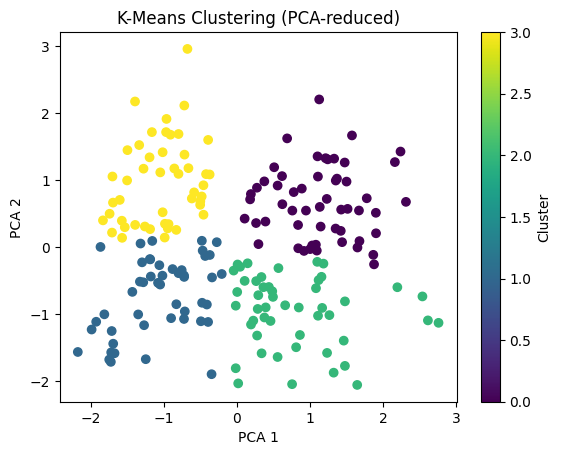

In [76]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.colorbar(label='Cluster')
plt.show()

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

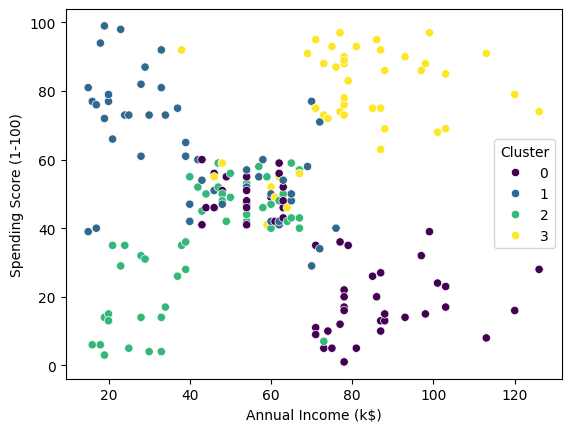

In [77]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')

In [78]:
print("Silhouette Score:", silhouette_score(X, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, labels))

Silhouette Score: 0.396869291988184
Davies-Bouldin Index: 0.8559787837996227


In [79]:
new = pd.DataFrame([[1, 30, 70, 60]], columns=['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

# Apply same transformations
new_scaled = scaler.transform(new)
new_pca = pca.transform(new_scaled)

# Predict cluster
predicted_cluster = kmeans.predict(new_pca)
print("Predicted Cluster:", predicted_cluster[0])

Predicted Cluster: 3


/Users/hashibk/Documents/Internship/week3/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [80]:
X = df.drop(columns=['Cluster'])
y = df['Cluster']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [82]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf, param_grid, cv = 5, scoring='accuracy', n_jobs=-1, verbose =1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Train Accuracy:", grid.best_score_)
print("Test Accuracy:", grid.best_estimator_.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, grid.best_estimator_.predict(X_test)))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Train Accuracy: 0.9558467741935484
Test Accuracy: 0.975

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        10
           3       0.92      1.00      0.96        12

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.98        40
weighted avg       0.98      0.97      0.97        40



In [83]:
"""X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# ------------------------------------------------------------------
# 4.  LightGBM model
# ------------------------------------------------------------------
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=y.nunique(),
    random_state=42,
)

# ------------------------------------------------------------------
# 5.  Parameter grid  (moderate‑size for demo)
# ------------------------------------------------------------------
param_grid = {
    'n_estimators'      : [100, 200],
    'learning_rate'     : [0.05, 0.1],
    'max_depth'         : [3, 5],     # -1 = no limit
    'num_leaves'        : [31, 63],        # should be <= 2^(max_depth)
    'min_child_samples' : [10, 20],
    'subsample'         : [0.8, 1.0],      # row sampling
    'colsample_bytree'  : [0.8, 1.0],      # feature sampling
}

# ------------------------------------------------------------------
# 6.  Grid search with 5‑fold stratified CV
# ------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',      # or 'f1_macro'
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# ------------------------------------------------------------------
# 7.  Results
# ------------------------------------------------------------------
print("Best Params :", grid.best_params_)
print("CV Accuracy :", grid.best_score_)

best_lgbm = grid.best_estimator_

y_pred = best_lgbm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))"""

'X_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.25, stratify=y, random_state=42\n)\n\n# ------------------------------------------------------------------\n# 4.  LightGBM model\n# ------------------------------------------------------------------\nlgbm = LGBMClassifier(\n    objective=\'multiclass\',\n    num_class=y.nunique(),\n    random_state=42,\n)\n\n# ------------------------------------------------------------------\n# 5.  Parameter grid  (moderate‑size for demo)\n# ------------------------------------------------------------------\nparam_grid = {\n    \'n_estimators\'      : [100, 200],\n    \'learning_rate\'     : [0.05, 0.1],\n    \'max_depth\'         : [3, 5],     # -1 = no limit\n    \'num_leaves\'        : [31, 63],        # should be <= 2^(max_depth)\n    \'min_child_samples\' : [10, 20],\n    \'subsample\'         : [0.8, 1.0],      # row sampling\n    \'colsample_bytree\'  : [0.8, 1.0],      # feature sampling\n}\n\n# ----------------------